# Plot rLow, rSurf, hFac from update_masks_etc

1. Scratch work to debug smooth computation of hFac
2. Look at differences in smooth and regular versions of these variables
3. Look at impact of `smoothAbsFuncRange` parameter

In [1]:
import os
import sys
import numpy as np
import xarray as xr
import xgcm
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt

# local functions
from plotUpdateMasksDebug import quickplot 

In [2]:
#grid_dir = '../../grids/pig_08'
regular_dir = '/workspace/ase-adjoint/pig/no-ecco/run_ad_08_nodepth'
smooth_dir = '/workspace/ase-adjoint/pig/generic/run_ad_08'
rough_dir = '/workspace/ase-adjoint/pig/generic/run_ad_08_notsmooth'

ds = open_mdsdataset(data_dir=regular_dir,
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_sm = open_mdsdataset(data_dir=smooth_dir,
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_ns = open_mdsdataset(data_dir=rough_dir,
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)


/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [3]:
xc = ds_sm['XC']
xg = ds_sm['XG']
yc = ds_sm['YC']
yg = ds_sm['YG']

In [4]:
fig_dir = 'figures/smooth_hfac'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

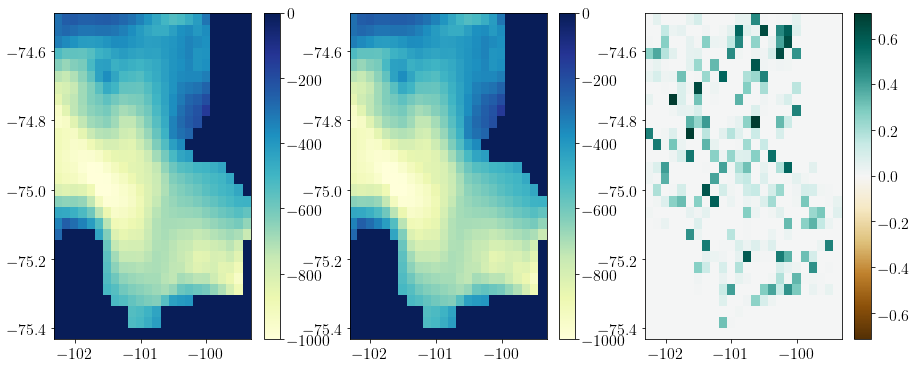

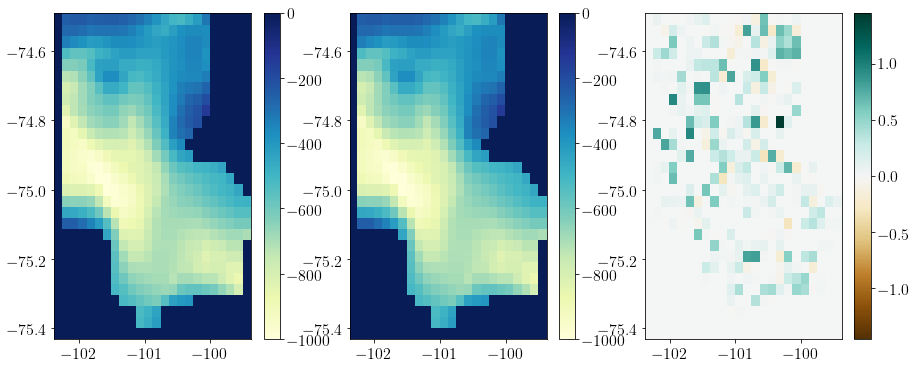

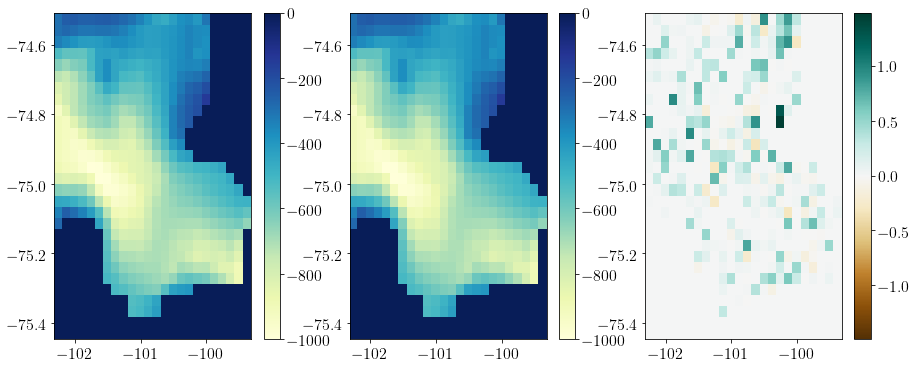

In [5]:
zlev=1
quickplot(xc,yc,ds_ns['rLowC'],ds_sm['rLowC'])
          #filename=('%s/rLowC_ns_sm_diff' % fig_dir))
quickplot(xg,yc,ds_ns['rLowW'],ds_sm['rLowW'])
          #filename=('%s/rLowW_ns_sm_diff' % fig_dir))
quickplot(xc,yg,ds_ns['rLowS'],ds_sm['rLowS'])
          #filename=('%s/rLowS_ns_sm_diff' % fig_dir))

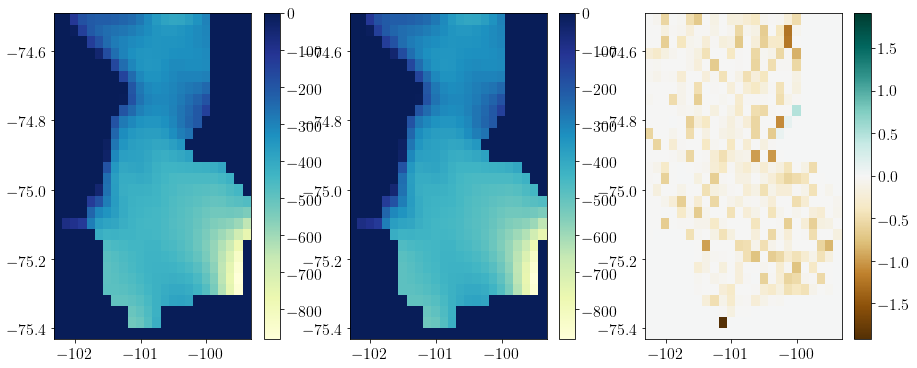

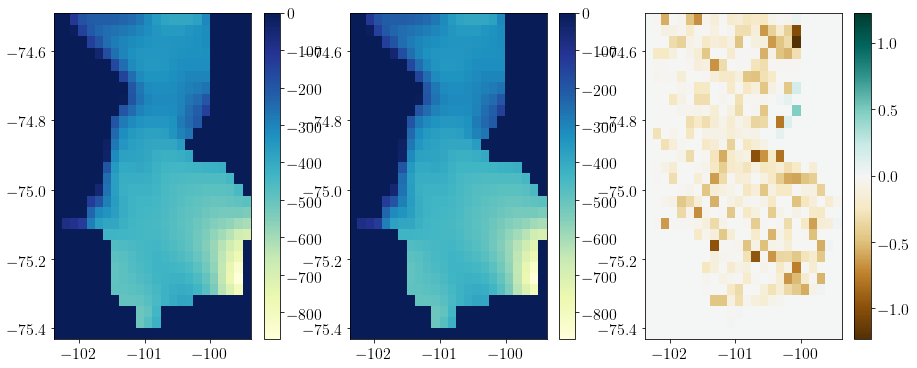

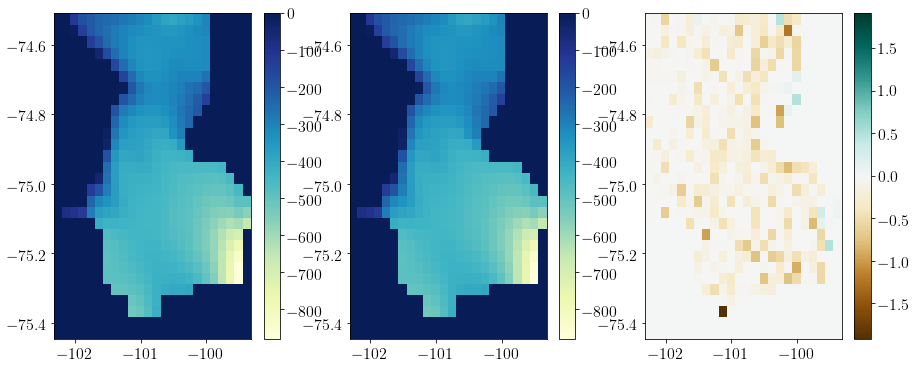

In [6]:
quickplot(xc,yc,ds_ns['rSurfC'],ds_sm['rSurfC'])
quickplot(xg,yc,ds_ns['rSurfW'],ds_sm['rSurfW'])
quickplot(xc,yg,ds_ns['rSurfS'],ds_sm['rSurfS'])

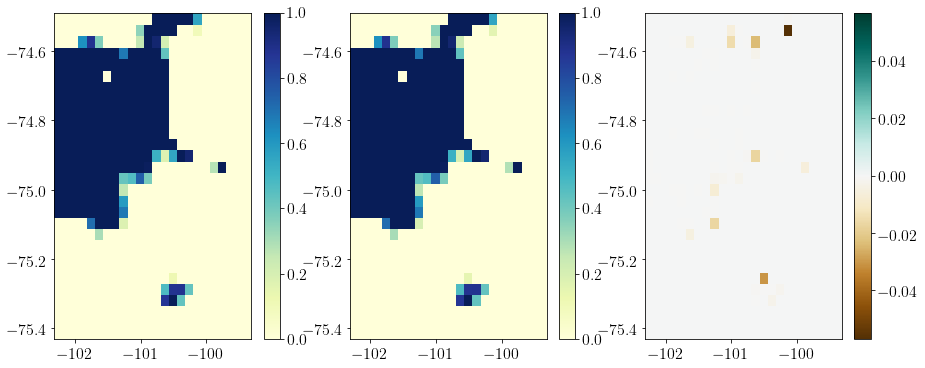

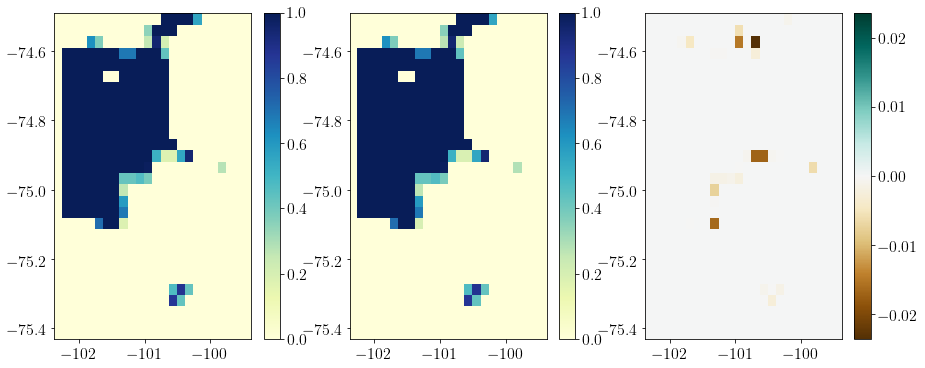

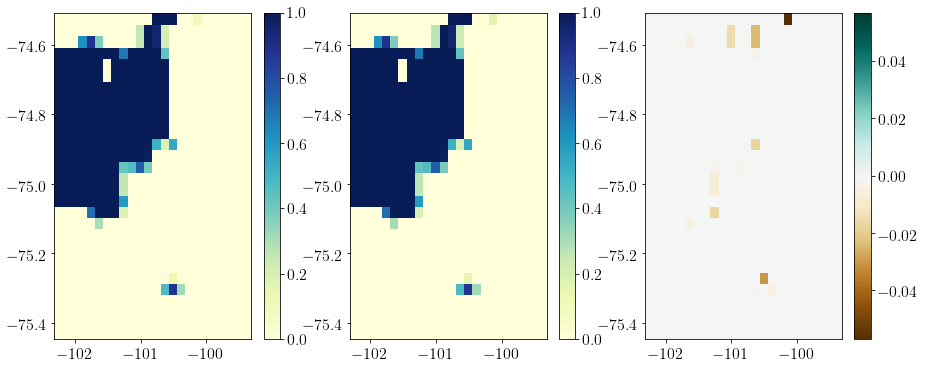

In [7]:
zlev=20
quickplot(xc,yc,ds_ns['hFacC'].isel(Z=zlev),ds_sm['hFacC'].isel(Z=zlev))
quickplot(xg,yc,ds_ns['hFacW'].isel(Z=zlev),ds_sm['hFacW'].isel(Z=zlev))
quickplot(xc,yg,ds_ns['hFacS'].isel(Z=zlev),ds_sm['hFacS'].isel(Z=zlev))

## hFacMin issues

Noticed that hFacW and hFacS were reaching values of hFacMin - 10$^{-5}$. 
- Changing `smoothAbsFuncRange` to 10$^{-9}$ etc. doesn't help
- replacing `smooth_hFac_rl` calls with `reg_hFac_rl` calls in `update_masks_etc` eliminates these cells, `smoothmax` not a problem, hence why changing `smoothAbsFuncRange` doesn't matter
- Modifying `hFacMin`=0.11 (rather than 0.1) brute force fixes the problem
- This is NOT an issue of `_RS` -vs- `_RL` because `_RL`=`_RS`=`REAL*8` unless `LET_RS_BE_REAL4` is defined (see `EEOPTIONS.h`)
- 

But how is `hFacMin` set in the first place? ad hoc? 

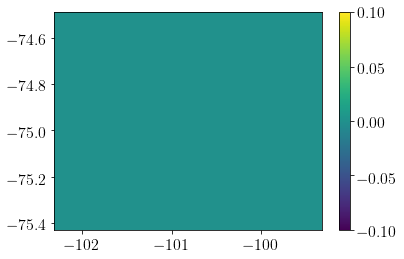

In [8]:
zlev = 10
hFacMin = 0.10
#quickplot(xc,yc,ds['hFacC'],ds_sm['hFacC'],z_level=zlev)
plt.figure()
tmp = ds_sm['hFacC'].where((ds_sm['hFacC']>0) & (ds_sm['hFacC']<hFacMin))
tmp = hFacMin - tmp
tmp = tmp.sum('Z')#isel(Z=zlev)
plt.pcolormesh(xc,yc,tmp)
plt.colorbar()
plt.show()


Ok my solution for now is to set `hFacMin`=0.11 so that the run is stable despite these weird differences. 

BUT this causes some blow up ... which is clearly originating at these weird points so need to get to the bottom of it. 

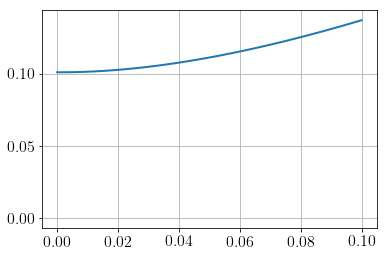

0.10095480107028801


In [9]:
import plotSmoothMin as psm

x = np.arange(0,hFacMin,.0001)
y = psm.smooth_hFac(x,hFacMin=hFacMin,minThreshold=False)
cond = (y<hFacMin) & (y>0)
plt.figure()
plt.plot(x,y)
plt.plot(np.where(cond,x,0),np.where(cond,y,0))
plt.grid()
plt.show()

hFacMin
x0 = 0.0000001
print(x0 + 1.01*hFacMin * np.exp(x0/hFacMin)-np.exp(-1/hFacMin))

This is just to show that there are some small values for `rF - rLow` for which `hFac` can be nonzero and below `hFacMin`. 

This can be addressed two ways:
1. Adding a 1.01 factor to hFacMin in the `smooth_hFac` function as shown above
2. Thresholding so that `rF - rLow` < $\epsilon$, where $\epsilon \sim 0.001 \implies$ hFac = 0. 

But either way, using this exact form results in blowup within the iceshelf domain ... and the solution that fixes the blow up will likely fixs this anyway.

### Now that smooth_min works in forward, test effect of smoothing parameter

"works" as in when using the halfThreshold version the code runs, but there's visible noise in the state. Need to investigate this more, and it seems from below that the particular version of smoothmin or smoothmax is not super important.

In [10]:

ds_sm_m0 = open_mdsdataset(data_dir='/workspace/results/pig/smooth_min/absFunc_1e0',
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_sm_m1 = open_mdsdataset(data_dir='/workspace/results/pig/smooth_min/absFunc_1e-1',
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_sm_m2 = open_mdsdataset(data_dir='/workspace/results/pig/smooth_min/absFunc_1e-2',
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_sm_m3 = open_mdsdataset(data_dir='/workspace/results/pig/smooth_min/absFunc_1e-3',
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)
ds_sm_m4 = open_mdsdataset(data_dir='/workspace/results/pig/smooth_min/absFunc_1e-4',
                     geometry='sphericalpolar',
                     ignore_unknown_vars=True)

/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/smooth_min/absFunc_1e0. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/utils.py:429: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/workspace/xmitgcm/xmitgcm/mds_store.py:269: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:
/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/results/pig/smooth_min/absFunc_1e-1. Using default version.
  "in %s. Using default version." % data_dir)
/workspace/xmitgcm/xmitgcm/mds_store.py:811: UserWarning: Couldn't find available_diagnostics.log in /workspace/re

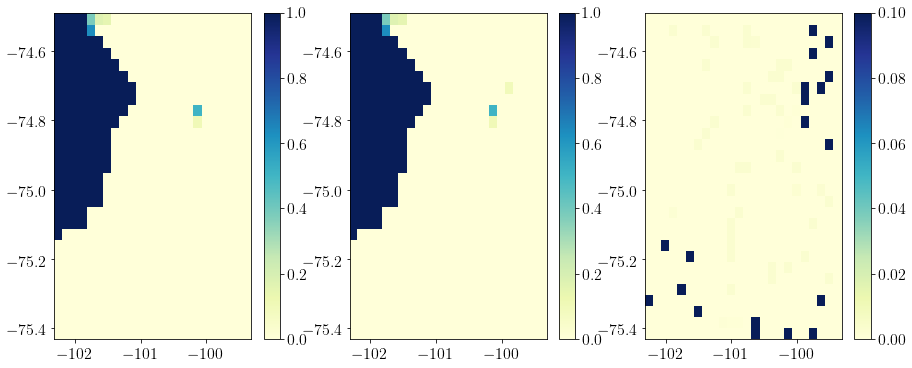

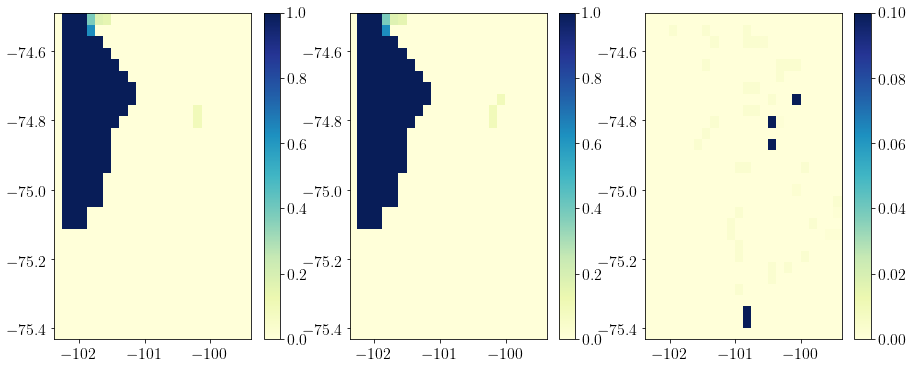

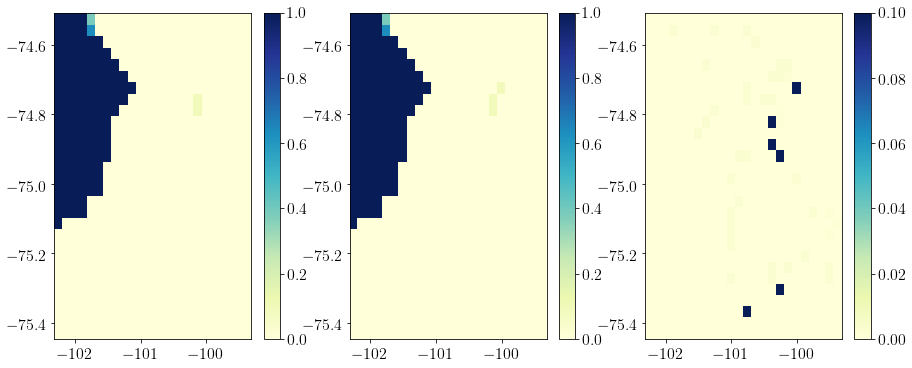

In [11]:
zlev=10
quickplot(xc,yc,ds_sm_m4['hFacC'],ds_sm_m1['hFacC'],z_level=zlev)
quickplot(xg,yc,ds_sm_m4['hFacW'],ds_sm_m1['hFacW'],z_level=zlev)
quickplot(xc,yg,ds_sm_m4['hFacS'],ds_sm_m1['hFacS'],z_level=zlev)

After some testing, it really seems like `smoothAbsFuncRange` = $10^{-3}$ or $10^{-4}$ would be fine for hFac ... will choose $10^{-4}$ just to be safe ...